# **Import Libraries**

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

# **LOAD DATASET**

In [83]:
# Load the Titanic dataset
titanic_data = pd.read_csv('/content/titanic.csv')

In [84]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [85]:
titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [86]:
# Create a scatter plot of Age vs Fare
chart = alt.Chart(titanic_data).mark_point().encode(
    x='Age',
    y='Fare'
).interactive()

# Create a histogram of Age
histogram = alt.Chart(titanic_data).mark_bar().encode(
    x='Age:Q',
    y='count()'
)

# Combine the two charts into a vconcat
combined_chart = chart | histogram

# Display the combined chart
combined_chart


alt.HConcatChart(...)

# **PREPROCESSING**

In [87]:
def preprocess_data(df, is_training=True): # Add is_training flag
    # Fill missing values
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

    # Convert categorical variables into numeric
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

    # Drop columns that won't be used for the prediction, conditionally
    if is_training: # Only drop 'PassengerId' during training
        columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    else:
        columns_to_drop = ['Name', 'Ticket', 'Cabin']
    for column in columns_to_drop:
        if column in df.columns:
            df.drop(columns=[column], inplace=True)

    return df

In [88]:
# Preprocess the dataset, indicating it's for training
titanic_data = preprocess_data(titanic_data, is_training=True)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,0
1,1,1,1,38.0,1,0,71.2833,1
2,1,3,1,26.0,0,0,7.9250,0
3,1,1,1,35.0,1,0,53.1000,0
4,0,3,0,35.0,0,0,8.0500,0


In [89]:
# Calculate the correlation matrix
corr_matrix = titanic_data.corr()

# Select the Survived column
survived_corr = pd.Series(corr_matrix['Survived'])

# Sort the correlations in descending order
sorted_corr = survived_corr.sort_values(ascending=False)

# Print the top 5 correlations
print(sorted_corr.head(5))


Survived    1.000000
Sex         0.543351
Fare        0.257307
Embarked    0.106811
Parch       0.081629
Name: Survived, dtype: float64


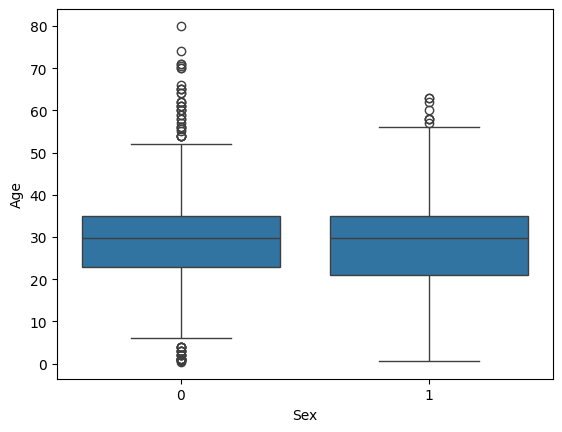

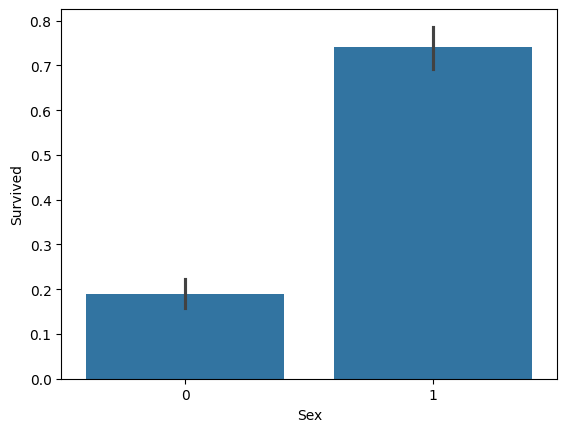

In [90]:
# Create a boxplot of Age for each Sex
sns.boxplot(x = "Sex", y = "Age", data = titanic_data)
plt.show()

# Create a bar chart of Survived vs Sex
sns.barplot(x = "Sex", y = "Survived", data = titanic_data)
plt.show()


In [91]:
# Preprocess the dataset, indicating it's for testing
titanic_data = preprocess_data(titanic_data, is_training=False)
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,NaN,22.0,1,0,7.2500,NaN
1,1,1,NaN,38.0,1,0,71.2833,NaN
2,1,3,NaN,26.0,0,0,7.9250,NaN
3,1,1,NaN,35.0,1,0,53.1000,NaN
4,0,3,NaN,35.0,0,0,8.0500,NaN


# **Contingency Table**

In [92]:
# Reload the titanic dataset before preprocessing for testing
titanic_data = pd.read_csv('/content/titanic.csv')

# Preprocess the dataset, indicating it's for testing
titanic_data = preprocess_data(titanic_data, is_training=False)

In [93]:
# Check if the DataFrame is empty
if titanic_data.empty:
    print("Warning: DataFrame is empty after preprocessing for testing.")
else:
    # Check for missing values in 'Sex' and 'Survived' columns
    print(titanic_data['Sex'].isnull().sum())
    print(titanic_data['Survived'].isnull().sum())

    # If there are missing values, handle them appropriately (e.g., imputation or removal) before creating the contingency table.
    # For example, to drop rows with missing values in either 'Sex' or 'Survived':
    titanic_data.dropna(subset=['Sex', 'Survived'], inplace=True)

    # Create a contingency table of sex and survival
    sex_survival = pd.crosstab(titanic_data['Sex'], titanic_data['Survived'])

    print("Contingency Table (Sex vs Survived):")
    print(sex_survival)

    # Perform a chi-square test on the contingency table
    chi2, p, dof, expected = chi2_contingency(sex_survival)

    # Print the results of the chi-square test
    print("Chi-square test statistic:", chi2)
    print("P-value:", p)

    # Create a contingency table of pclass and survival
    pclass_survival = pd.crosstab(titanic_data['Pclass'], titanic_data['Survived'])

    print("Contingency Table (Pclass vs Survived):")
    print(pclass_survival)

    # Perform a chi-square test on the contingency table
    chi2, p, dof, expected = chi2_contingency(pclass_survival)

    # Print the results of the chi-square test
    print("Chi-square test statistic:", chi2)
    print("P-value:", p)

0
0
Contingency Table (Sex vs Survived):
Survived    0    1
Sex               
0         468  109
1          81  233
Chi-square test statistic: 260.71702016732104
P-value: 1.1973570627755645e-58
Contingency Table (Pclass vs Survived):
Survived    0    1
Pclass            
1          80  136
2          97   87
3         372  119
Chi-square test statistic: 102.88898875696056
P-value: 4.549251711298793e-23


# **Define feature and the target variable**

In [94]:
# Define feature variables (X) and the target variable (y)
X = titanic_data.drop(columns=['Survived'])
y = titanic_data['Survived']

# **Splitting Testing and Training Data**

In [95]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Random Forest Classifier**

In [96]:
# Initialize and train the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 81.56%


In [103]:
# Function to predict survival based on input data
def predict_survival(data):
    data = preprocess_data(pd.DataFrame([data]), is_training=False)

    # Get the feature names the model was trained on
    training_features = X_train.columns

    # Check if 'PassengerId' is in training features and add it if missing
    if 'PassengerId' in training_features:
        # If 'PassengerId' was in training data, add a dummy value to the new data
        data['PassengerId'] = 0  # Or any placeholder value

    # Ensure the new data has the same features and in the same order
    data = data[training_features]

    prediction = model.predict(data)
    return 'Survived' if prediction[0] == 1 else 'Did not survive'

In [104]:
# Example usage
new_passenger = {
    'Pclass': 3,
    'Sex': 'male',
    'Age': 22,
    'SibSp': 1,
    'Parch': 0,
    'Fare': 7.25,
    'Embarked': 'S'
}

print(predict_survival(new_passenger))

Did not survive
